# Building an Movie Recommendation System

# Preprocessing

In [4]:
# import necessary libraries
import random
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import clear_output
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from surprise import Reader, Dataset, SVD, KNNBasic, KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise.model_selection import cross_validate

#ignore warnings
warnings.filterwarnings("ignore")

In [5]:
# import datasets
movies=pd.read_csv('movies.csv')
ratings=pd.read_csv('ratings.csv')

In [6]:
movies.info() # 62k+ movies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [7]:
ratings.info() # 25 million ratings

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [8]:
movies.shape

(62423, 3)

In [9]:
ratings.shape

(25000095, 4)

In [10]:
df = pd.merge(ratings, movies, how='left', on='movieId') # merged dataset
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


# Exploratory Analysis

In [11]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


<AxesSubplot:xlabel='rating', ylabel='Density'>

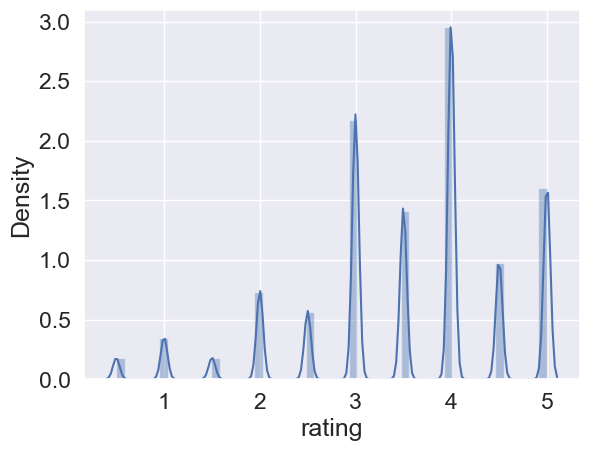

In [9]:
# display distribution of rating
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
%matplotlib inline

sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

# Content based filtering
Here we build a recommendation engine that computes similarities between the movies based on genres.
TF-IDF determines the importance of an item based on its frequency.
Using cosine similarity we can determine which items are closer to each other.

In [10]:
cv = TfidfVectorizer()
tfidf_matrix = cv.fit_transform(movies['genres'])

In [11]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [12]:
# basic recommendations function
indices = pd.Series(movies.index,index=movies['title'])
titles = movies['title']
def recommendations(title):
    idx = indices[title]
    sim = list(enumerate(cosine_sim[idx]))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    sim = sim[1:21]
    movie_indices = [i[0] for i in sim]
    return titles.iloc[movie_indices]

In [13]:
recommendations('Shrek (2001)')

16033                               Gnomeo & Juliet (2011)
17686        Puss in Boots (Nagagutsu o haita neko) (1969)
0                                         Toy Story (1995)
2203                                           Antz (1998)
3021                                    Toy Story 2 (1999)
3653        Adventures of Rocky and Bullwinkle, The (2000)
3912                      Emperor's New Groove, The (2000)
4780                                 Monsters, Inc. (2001)
9949     DuckTales: The Movie - Treasure of the Lost La...
10773                                     Wild, The (2006)
11604                               Shrek the Third (2007)
12969                       Tale of Despereaux, The (2008)
17431    Asterix and the Vikings (Astérix et les Viking...
20015                                         Turbo (2013)
22286                                       Aladdin (1992)
22353                                Boxtrolls, The (2014)
22633            Toy Story Toons: Hawaiian Vacation (201

In [14]:
# **ADDING USER INTERACTION**

In [15]:
# idea: only ask about movies that received higher average rankings
# otherwise there too many possibilities (we could only ask about movies that are very unpopular and not-known)
high_ranking_movies = df.groupby(['title']).mean().sort_values(by=['rating'], ascending=False).head(1000).reset_index()
ranking_titles = high_ranking_movies['title']

In [16]:
def get_random_movie():
    rand = random.randint(0, 1000)
    return ranking_titles.iloc[rand]

In [17]:
# get a random movie out of 20 most likely to be liked
# print its name and how likely you are to like it
def get_random_recommendations(title):
    idx = indices[title]
    sim = list(enumerate(cosine_sim[idx]))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    rand = random.randint(1, 21)
    sim = sim[rand]
    movie_indices = sim[0]
    movie_predictions = sim[1]
    print(f"If you liked {title}, you might also like {titles.iloc[movie_indices]} (with {movie_predictions*100:.1f}% accuracy)\n") 

In [20]:
while True:
    rand_movie = get_random_movie()
    liked = input(f">> Did you like {rand_movie}?\n\nPrint y/n. \n")
    if liked == "n":
        clear_output()
        continue
    else:
        while True:
            get_random_recommendations(rand_movie)
            if input(f">> Are you going to watch this movie? (y/n) \n\n") != "y":
                continue
            else:
                print(">> Enjoy the movie! ")
                break 
        break

>> Did you like Céline (1992)?

Print y/n. 
y
If you liked Céline (1992), you might also like Restoration (1995) (with 100.0% accuracy)

>> Are you going to watch this movie? (y/n) 

y
>> Enjoy the movie! 


Seems to work, recommending movies of similar genre.

**Drawback**: Only recommends similar movies, doesn't capture tastes of a particular user.

# Collaborative Filtering Recommendation Model

In [18]:
# CHOOSING MODEL WITH CROSS VALIDATION

In [19]:
reader = Reader(line_format=u'rating user item', sep=',', rating_scale=(1, 6), skip_lines=1)

In [20]:
ratings=pd.read_csv('ratings.csv')
small_ratings = ratings.sample(frac=0.004).drop(['timestamp'], axis=1)
small_ratings.shape

(100000, 3)

In [21]:
ratings = Dataset.load_from_df(small_ratings[['userId', 'movieId', 'rating']][:], reader)

In [22]:
# Item based collaborative filtering with KNN

In [25]:
cross_validate(KNNBasic(), ratings, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0623  1.0636  1.0618  1.0626  0.0008  
MAE (testset)     0.8437  0.8438  0.8418  0.8431  0.0009  
Fit time          27.48   28.52   27.44   27.81   0.50    
Test time         1.13    1.00    1.02    1.05    0.06    


{'test_rmse': array([1.0622777 , 1.06362217, 1.06178661]),
 'test_mae': array([0.84368718, 0.84380173, 0.84181946]),
 'fit_time': (27.477945804595947, 28.522589921951294, 27.441742658615112),
 'test_time': (1.1287753582000732, 0.9957361221313477, 1.0167748928070068)}

Tested other KNN Models from the Surprise library (but my computer could not recompute them again). Their score were around the same.

In [26]:
# User Based Collaborative filtering with SVD

Users similar to each other in taste can be used to make predictions. Model-based Collaborative Filtering is based on matrix factorization - SVD.

In [27]:
svd = SVD()

In [28]:
cross_validate(svd, ratings, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9847  0.9749  0.9736  0.9777  0.0049  
MAE (testset)     0.7647  0.7565  0.7552  0.7588  0.0042  
Fit time          0.81    0.68    0.67    0.72    0.06    
Test time         0.14    0.13    0.13    0.13    0.00    


{'test_rmse': array([0.98465022, 0.97487906, 0.9736169 ]),
 'test_mae': array([0.76465057, 0.75649912, 0.75517146]),
 'fit_time': (0.8078680038452148, 0.6834521293640137, 0.6726078987121582),
 'test_time': (0.13535594940185547, 0.13234782218933105, 0.13183212280273438)}

**RMSE is quite high**, but it **goes down the bigger the sample** (cannot make it too big during cross-validation based on computational restrictions).

**SVD (user-based recommendation) shows the lowest RMSE**, thus, it is chosen for building the Recommender.

# Building a Recommender System with SVD

In [29]:
ratings=pd.read_csv('ratings.csv')
small_ratings = ratings.sample(frac=0.25).drop(['timestamp'], axis=1)

In [30]:
last_user = small_ratings['userId'].max()

In [31]:
def get_random_id_and_movie():
    rand = random.randint(0, 62423)
    return rand, titles.iloc[rand]

In [32]:
def create_new_user(new_id):
    n_inputs = 0
    while n_inputs < 5: # can change for better accuracy 
        movie_id, movie = get_random_id_and_movie()
        rating = input(f"How would you rate the movie {movie}? (rating/-)")
        if rating != '-':
            small_ratings.append([new_id, movie_id, rating])
            n_inputs+=1
    print(f"You are now a user. Your id is {new_id}! ")

In [33]:
def make_recommendations(user_id):
    user_data = movies.copy()
    user_data = user_data.reset_index()
    
    data = Dataset.load_from_df(small_ratings[['userId', 'movieId', 'rating']][:], reader)

    trainset = data.build_full_trainset()
    print("Please wait for you recommendations...")
    svd.fit(trainset)

    user_data["Estimate_Score"] = user_data['movieId'].apply(lambda x: svd.predict(user_id, x).est)

    user_data = user_data.drop("movieId", axis = 1)

    user_data = user_data.sort_values("Estimate_Score", ascending=False) 
    print(user_data.head(10))

In [34]:
while True:
    if input("Are you a new user? (y/n) ") == "y":
        print(f"Welcome!\nFirst, tell us more about your preferences. ")
        last_user = small_ratings['userId'].max()
        create_new_user(last_user+1)
    else:
        user_id = int(input("Input your id: "))
        print("Here are your recommendations:")
        make_recommendations(user_id)
        break

Are you a new user? (y/n) y
Welcome!
First, tell us more about your preferences. 
How would you rate the movie Fortini/Cani (1977)? (rating/-)-
How would you rate the movie A Lovely Way to Die (1968)? (rating/-)-
How would you rate the movie Baba Yaga (1971)? (rating/-)4
How would you rate the movie Shaka Zulu (1986)? (rating/-)-
How would you rate the movie Sabotage (1936)? (rating/-)-
How would you rate the movie 12 Days (2017)? (rating/-)5
How would you rate the movie Slave of Love, A (Raba lyubvi) (1976)? (rating/-)-
How would you rate the movie The End of Time (2012)? (rating/-)4
How would you rate the movie Princess O'Rourke (1943)? (rating/-)-
How would you rate the movie Scream 4 (2011)? (rating/-)5
How would you rate the movie Final Fantasy: The Spirits Within (2001)? (rating/-)5
You are now a user. Your id is 162542! 
Are you a new user? (y/n) n
Input your id: 162542
Here are your recommendations:
Please wait for you recommendations...
       index                            